In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as td
import torchvision
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time

In [ ]:
gpu_boole = torch.cuda.is_available()
print(gpu_boole) ##If True, then your GPU is enabled and you are able to make use of it

True


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5)])

training = dataset.FashionMNIST(root ='./data', transform=transforms.ToTensor(), train=True, download=True)
testing =  dataset.FashionMNIST(root ='./data', transform = transforms.ToTensor(), train=False, download=True)

train, valid = td.random_split(training, [50000, 10000], generator=torch.Generator().manual_seed(42))

train_loader = torch.utils.data.DataLoader(dataset=train, batch_size = 128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid, batch_size = 128, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=testing, batch_size = 128, shuffle=False)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


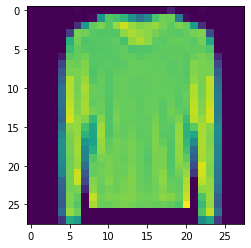



Label tensor(2)


In [ ]:
## Plotting data to make sure it is correct:
x,y = next(iter(train_loader))
plt.imshow(x[3][0].cpu().data.numpy()) #plotting first channel of first image of MNIST
plt.show()
print('Label', y[3])

In [ ]:
class Net(nn.Module):
  def __init__(self, num_classes):
    super(Net, self).__init__()

    ##convolutional layers
    self.conv1 = nn.Conv2d(1, 15, 3)
    self.conv2 = nn.Conv2d(15, 20, 3)

    #linear layers
    self.ff1 = nn.Linear(20 * 5 * 5, 80) #hidden layers
    self.ff_out = nn.Linear(80, num_classes)   

    ##activation:
    self.relu = nn.ReLU()

    #pooling:
    self.pool = nn.MaxPool2d(2, 2)

                
  def forward(self, input_data):
    out = self.relu(self.pool(self.conv1(input_data)))
    out = self.relu(self.pool(self.conv2(out)))
    out = out.view(-1, 20*5*5)
    out = self.relu(self.ff1(out))
    out = self.relu(self.ff_out(out))
    return out #returns class probabilities for each image

In [ ]:
def train_eval(net, loss_metric, verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for images, labels in train_loader:
        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()

        loss_sum += loss_metric(outputs,labels)
        
        
    if verbose:
        print('Train accuracy: %f %%' % (100.0 * correct / total))
        print('Train loss: %f' % (loss_sum.cpu().data.numpy().item() / total))

    return 100.0 * correct / total, loss_sum.cpu().data.numpy().item() / total


def valid_eval(net, loss_metric, verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for images, labels in valid_loader:
        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()

        loss_sum += loss_metric(outputs,labels)

    if verbose:
        print('Validation accuracy: %f %%' % (100.0 * correct / total))
        print('Validation loss: %f' % (loss_sum.cpu().data.numpy().item() / total))

    return 100.0 * correct / total, loss_sum.cpu().data.numpy().item() / total
    

def test_eval(net, loss_metric, verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for images, labels in test_loader:
        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()

        loss_sum += loss_metric(outputs,labels)

    if verbose:
        print('Test accuracy: %f %%' % (100.0 * correct / total))
        print('Test loss: %f' % (loss_sum.cpu().data.numpy().item() / total))

    return 100.0 * correct / total, loss_sum.cpu().data.numpy().item() / total

In [ ]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.fill_(0)

def train(net, loss_metric, optimizer, epochs=100):
    #defining batch train loss recording arrays for later visualization/plotting:
    loss_batch_store = []
    valid_acc = []

    print("Starting Training")
    #training loop:
    for epoch in range(epochs):
      time1 = time.time() #timekeeping

      for i, (x,y) in enumerate(train_loader):

        if gpu_boole:
          x = x.cuda()
          y = y.cuda()

        #loss calculation and gradient update:
        optimizer.zero_grad()

        outputs = net.forward(x)
        loss = loss_metric(outputs,y)
        loss.backward()    

        ##performing update:
        optimizer.step()

      print("Epoch",epoch+1,':')
      train_perc, train_loss = train_eval(net, loss_metric)
      valid_perc, valid_loss = valid_eval(net, loss_metric)

      valid_acc.append(valid_perc)
      loss_batch_store.append(train_loss)

      time2 = time.time() #timekeeping
      print('Elapsed time for epoch:',time2 - time1,'s')
      print('ETA of completion:',(time2 - time1)*(epochs - epoch - 1)/60,'minutes')
      print()

    return loss_batch_store, valid_acc



Starting Training
Epoch 1 :
Train accuracy: 76.764000 %
Train loss: 0.004644
Validation accuracy: 75.519997 %
Validation loss: 0.004948
Elapsed time for epoch: 8.729554176330566 s
ETA of completion: 2.7643588225046796 minutes

Epoch 2 :
Train accuracy: 88.549995 %
Train loss: 0.002420
Validation accuracy: 87.689995 %
Validation loss: 0.002678
Elapsed time for epoch: 8.506126642227173 s
ETA of completion: 2.551837992668152 minutes

Epoch 3 :
Train accuracy: 89.909996 %
Train loss: 0.002163
Validation accuracy: 88.659996 %
Validation loss: 0.002492
Elapsed time for epoch: 8.778139114379883 s
ETA of completion: 2.487139415740967 minutes

Epoch 4 :
Train accuracy: 91.009995 %
Train loss: 0.001862
Validation accuracy: 89.470001 %
Validation loss: 0.002232
Elapsed time for epoch: 8.829385995864868 s
ETA of completion: 2.3545029322306315 minutes

Epoch 5 :
Train accuracy: 91.178001 %
Train loss: 0.001846
Validation accuracy: 89.479996 %
Validation loss: 0.002253
Elapsed time for epoch: 8.9841

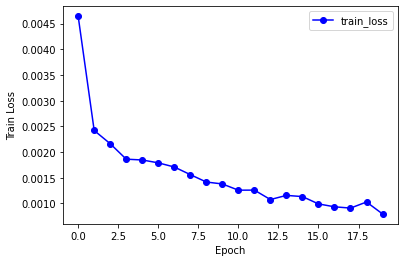

In [ ]:
torch.manual_seed(15)
net = Net(10)
if gpu_boole:
  net = net.cuda()

opt = torch.optim.Adam(net.parameters(), lr=0.005)
loss = nn.CrossEntropyLoss()
net.apply(weights_init)

loss_store, acc = train(net, loss, opt, 20)

## Plotting batch-wise train loss curve:
plt.plot(loss_store, '-o', label = 'train_loss', color = 'blue')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.legend()
plt.show()

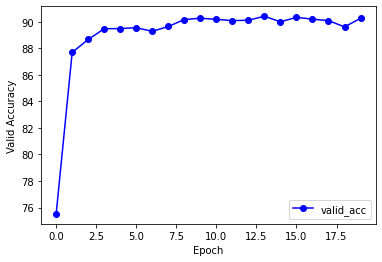

In [ ]:
plt.plot(acc, '-o', label = 'valid_acc', color = 'blue')
plt.xlabel('Epoch')
plt.ylabel('Valid Accuracy')
plt.legend()
plt.show()

In [ ]:
test_eval(net, loss, opt)

Test accuracy: 89.720001 %
Test loss: 0.003131


(tensor(89.7200, device='cuda:0'), 0.0031312038421630857)

###2b)

In [ ]:
class Net2(nn.Module):
  def __init__(self, num_classes):
    super(Net2, self).__init__()

    ##convolutional layers
    self.conv1 = nn.Conv2d(1, 15, 3)
    self.conv2 = nn.Conv2d(15, 20, 3)

    #linear layers
    self.ff1 = nn.Linear(20 * 5 * 5, 80) #hidden layers
    self.ff_out = nn.Linear(80, num_classes)   

    ##activation:
    self.relu = nn.ReLU()

    #pooling:
    self.pool = nn.MaxPool2d(2, 2)

    #dropout:
    self.do = nn.Dropout(p=0.2)

    #batch-normalization:
    self.bn1 = nn.BatchNorm2d(20)
    self.bn2 = nn.BatchNorm1d(80)

                
  def forward(self, input_data):
    out = self.relu(self.pool(self.conv1(input_data)))
    out = self.relu(self.pool(self.bn1(self.conv2(out))))
    out = out.view(-1, 20*5*5)
    out = self.do(out)
    out = self.relu(self.bn2(self.ff1(out)))
    out = self.relu(self.ff_out(out))
    return out #returns class probabilities for each image

Starting Training
Epoch 1 :
Train accuracy: 87.627998 %
Train loss: 0.002624
Validation accuracy: 86.849998 %
Validation loss: 0.002831
Elapsed time for epoch: 9.179226875305176 s
ETA of completion: 2.9067551771799724 minutes

Epoch 2 :
Train accuracy: 88.211998 %
Train loss: 0.002474
Validation accuracy: 87.439995 %
Validation loss: 0.002751
Elapsed time for epoch: 8.981194734573364 s
ETA of completion: 2.6943584203720095 minutes

Epoch 3 :
Train accuracy: 89.517998 %
Train loss: 0.002155
Validation accuracy: 88.360001 %
Validation loss: 0.002457
Elapsed time for epoch: 9.76419448852539 s
ETA of completion: 2.766521771748861 minutes

Epoch 4 :
Train accuracy: 90.603996 %
Train loss: 0.001969
Validation accuracy: 89.250000 %
Validation loss: 0.002326
Elapsed time for epoch: 9.49463415145874 s
ETA of completion: 2.5319024403889974 minutes

Epoch 5 :
Train accuracy: 91.139999 %
Train loss: 0.001840
Validation accuracy: 89.360001 %
Validation loss: 0.002250
Elapsed time for epoch: 8.97888

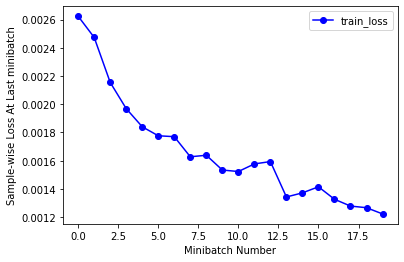

In [ ]:
torch.manual_seed(5)
net2 = Net2(10)
if gpu_boole:
  net2 = net2.cuda()

opt = torch.optim.Adam(net2.parameters(), lr=0.005)
loss = nn.CrossEntropyLoss()
net2.apply(weights_init)

loss_store, acc = train(net2, loss, opt, 20)



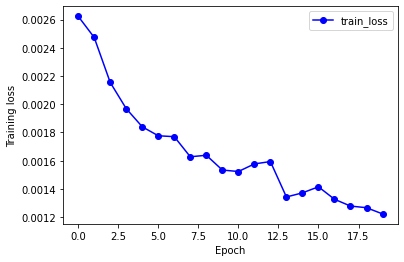

In [ ]:
## Plotting batch-wise train loss curve:
plt.plot(loss_store, '-o', label = 'train_loss', color = 'blue')
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.legend()
plt.show()

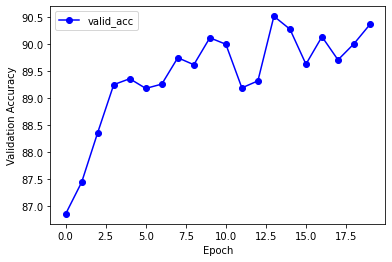

Test accuracy: 90.079994 %
Test loss: 0.002268


(tensor(90.0800, device='cuda:0'), 0.002267892646789551)

In [ ]:
plt.plot(acc, '-o', label = 'valid_acc', color = 'blue')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()
test_eval(net2, loss, opt)